In [0]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)

In [0]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

In [0]:
labels ={"label": {"correct": 1, "incorrect": 0}}
df.replace(labels, inplace=True)
df.head()

In [0]:
missing_indices = np.where(df['fare'].isnull())[0]
df.drop(df.index[missing_indices], inplace=True)

correct_indices = np.where(df['label']==1)[0]
incorrect_indices = np.where(df['label']==0)[0]

In [0]:
correct_df = df.drop(df.index[incorrect_indices])
correct_df.drop(columns='label', inplace=True)

incorrect_df = df.drop(df.index[correct_indices])
incorrect_df.drop(columns='label', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
fare_df = pd.DataFrame(correct_df['fare'])
correct_df.drop(columns='fare', inplace=True)

incorrect_fare = pd.DataFrame(incorrect_df['fare'])
incorrect_df.drop(columns='fare', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Working with the correct_df to make a models for correct fare values

In [0]:
def set_trip_time(df):
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()
    df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

set_trip_time(correct_df)
set_trip_time(incorrect_df)

In [0]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)

def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances
    feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], inplace=True)

# Calling the set_distance to set a distance column and remove coordinates columns
set_distance(correct_df)
set_distance(incorrect_df)

In [0]:
def set_time_error(feature_df):
    time_errors = []
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2
    #feature_df.drop(columns=['duration', 'trip_time'], inplace=True)

set_time_error(correct_df)
set_time_error(incorrect_df)

In [0]:
def add_missing_col(df):
    '''
        This function adds an additional binary column to the df based on all
        additional_fare, duration, meter_waiting, meter_waiting_fare, meter_waiting_till_pickup, time_error
        has NaN values
    '''
    df['ismissing'] = np.where(df[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error']].isnull().all(1), 1, 0)

add_missing_col(correct_df)
add_missing_col(incorrect_df)
correct_df.head()

In [0]:
def test_feature_process(feature_df):
    set_trip_time(feature_df)
    set_distance(feature_df)
    set_time_error(feature_df)
    add_missing_col(feature_df)
    test_fare = feature_df['fare']
    test_df = feature_df.drop(columns=['additional_fare', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error', 'ismissing', 'fare'])

    return (test_df, test_fare)

In [0]:
correct_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,trip_time,trip_distance,time_error,ismissing
count,15442.000000,15442.000000,15442.000000,15442.000000,15442.000000,15495.000000,15495.000000,15442.000000,15495.000000
mean,12.444340,1413.967232,356.655679,16.909938,107.549152,1415.244918,4.863254,601.525968,0.003420
std,10.913368,4186.012968,3997.973278,231.323228,446.786272,4179.765286,45.248851,741.138784,0.058386
min,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,552.000000,33.250000,0.000000,25.000000,540.000000,1.528000,64.000000,0.000000
50%,10.500000,1003.000000,122.000000,0.291035,71.000000,1020.000000,3.227000,324.000000,0.000000
75%,10.500000,1753.000000,340.000000,14.089896,141.000000,1740.000000,6.095000,900.000000,0.000000
max,221.000000,453872.000000,453650.000000,26198.601400,51288.000000,453840.000000,5609.521000,23409.000000,1.000000


# Handle Outliers

In [0]:
from scipy import stats
from sklearn.impute import SimpleImputer

def remove_outliers(xdf, ydf):
    columns = xdf.columns
    index = xdf.index.values
    simple_imputer = SimpleImputer(strategy='median')
    data = simple_imputer.fit_transform(xdf)
    xdf = pd.DataFrame(data=data, columns=columns, index=index)
    xdf.index.name = 'tripid'
    z = np.abs(stats.zscore(xdf.drop(columns='ismissing')))
    outliers = np.where(z > 2.5)[0]
    print(len(set(outliers)))
    xdf = xdf.drop(xdf.index[outliers])
    ydf = ydf.drop(ydf.index[outliers])

    return (xdf, ydf)

print("Before: {}|{}".format(correct_df.shape, fare_df.shape))
correct_df, fare_df = remove_outliers(correct_df, fare_df)
print("After: {}|{}".format(correct_df.shape, fare_df.shape))

Before: (15495, 9)|(15495, 1)
1114
After: (14381, 9)|(14381, 1)


In [0]:
correct_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,trip_time,trip_distance,time_error,ismissing
count,14381.00000,14381.000000,14381.000000,14381.000000,14381.000000,14381.000000,14381.000000,14381.000000,14381.000000
mean,10.50153,1324.750435,292.420972,13.179845,101.316807,1327.464015,4.457888,531.928169,0.003685
std,3.25539,1197.872151,521.013243,30.533840,112.644220,1201.812655,4.407770,592.548302,0.060598
min,0.00000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.50000,546.000000,32.000000,0.000000,24.000000,540.000000,1.510000,64.000000,0.000000
50%,10.50000,990.000000,120.000000,0.174900,71.000000,960.000000,3.185000,289.000000,0.000000
75%,10.50000,1718.000000,330.000000,13.294000,140.000000,1740.000000,6.027000,841.000000,0.000000
max,35.00000,11797.000000,9397.000000,547.845100,1205.000000,11820.000000,58.718000,2401.000000,1.000000


## Feature Coorelation

Text(0, 0.5, 'Pearson Coeerelation')

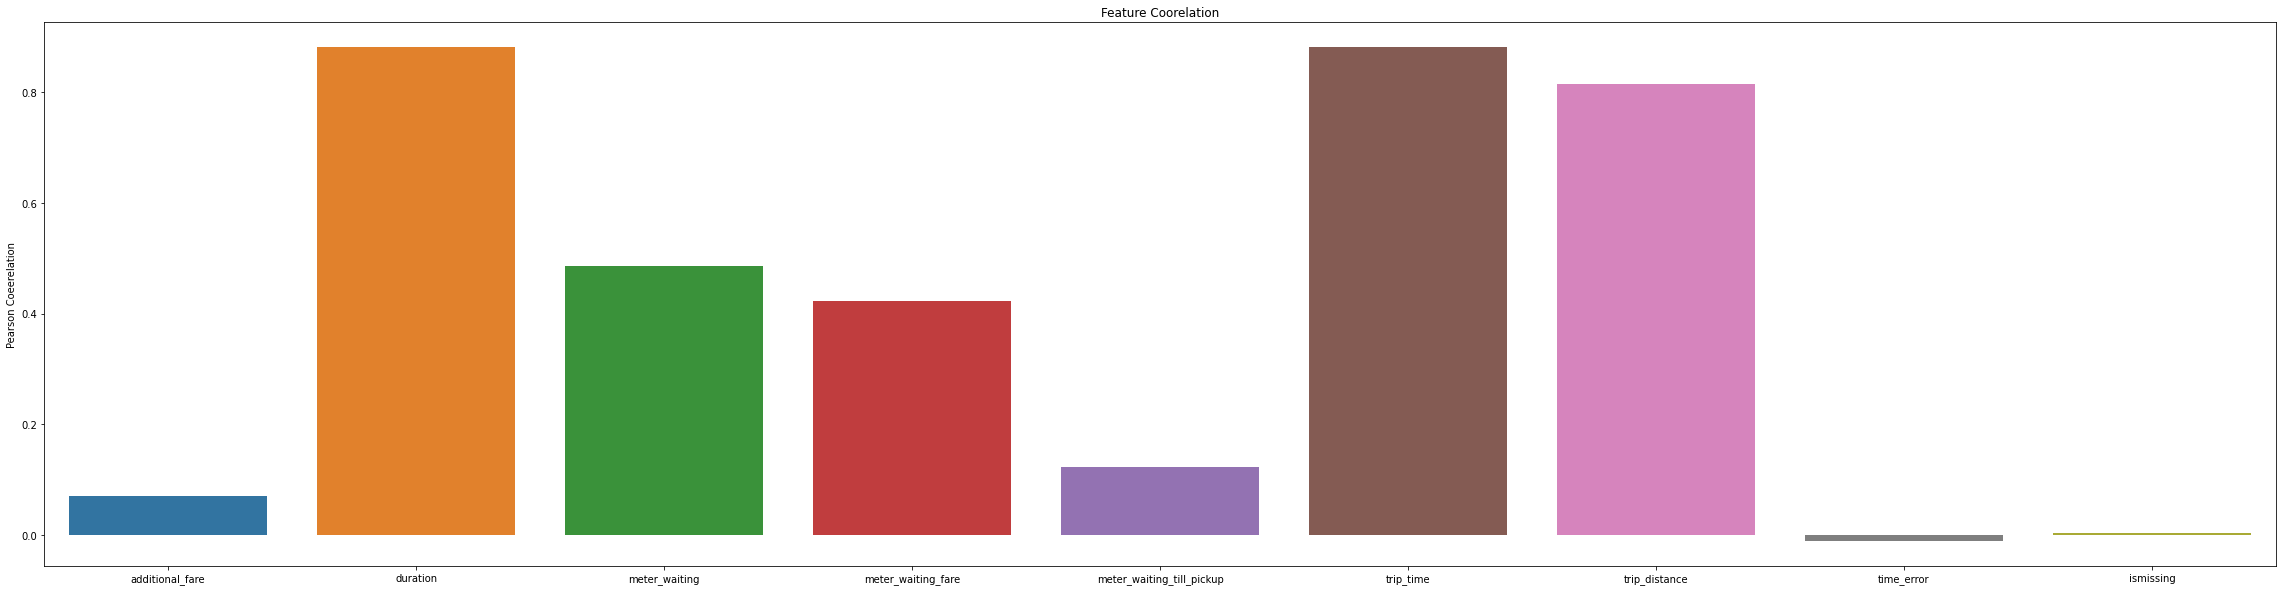

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

corr_df = correct_df.copy()
columns = corr_df.columns

cor = []
for col in columns:
    cor.append(corr_df[col].corr(fare_df['fare'], method="pearson"))

plt.figure(figsize=(40,10))
plt.title("Feature Coorelation")
sns.barplot(x=columns, y=cor)
plt.ylabel("Pearson Coeerelation")

In [0]:
correct_df.drop(columns=['additional_fare', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error', 'ismissing'], inplace=True)
incorrect_df.drop(columns=['additional_fare', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error', 'ismissing'], inplace=True)

# Building Models

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from xgboost.sklearn import XGBRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

## Setting-up the Pre-Processor

In [0]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

# SimpleImputer(strategy='median', add_indicator=False) - RandomForest model
# SimpleImputer(strategy='median', add_indicator=True) - LogisticRegression
# SimpleImputer(strategy='most_frequent', add_indicator=True) -XGBClassifier
preprocessor = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')), #, add_indicator=True
    ('scaler', MinMaxScaler())
])

# Train & Evaluation

### Building XGBoostWithEarlyStop esitimators to use with pipelines

In [0]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=50, test_size=0.2, 
                 eval_metric=['mae'], **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_train, y_train),(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [0]:
estimator = XGBoostRegressorWithEarlyStop(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse') #

# estimator = XGBRegressor(booster='dart', subsample=0.8, min_child_weight=1, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=1,
#                            colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000,
#                        importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                        njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='rmse', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                        validate_parameters=False)

In [0]:
#estimator=RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6)
#estimator = LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
# XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse') #, objective='binary:hinge'
#subsample=0.8, min_child_weight=1, max_depth=8/4, learning_rate=0.05, gamma=0.2, colsample_bytree=1, n_estimators=1000, objective='binary:logistic', silent=True, nthread=6, tree_method='hist', eval_metric='auc'

# estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=7, max_depth=15, learning_rate=0.01, gamma=0.4, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logistic',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='auc', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)

# estimator = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse')

# estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=1, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logitraw',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='rmse', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    correct_df,
    fare_df,
    test_size=0.33,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [0]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
print(preds)

incorrect_preds = full_pipeline.predict(incorrect_df)

[15:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:345.931	validation_1-rmse:354.088
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:342.646	validation_1-rmse:350.807
[2]	validation_0-rmse:339.394	validation_1-rmse:347.545
[3]	validation_0-rmse:336.175	validation_1-rmse:344.301
[4]	validation_0-rmse:332.987	validation_1-rmse:341.111
[5]	validation_0-rmse:329.833	validation_1-rmse:337.926
[6]	validation_0-rmse:326.71	validation_1-rmse:334.801
[7]	validation_0-rmse:323.619	validation_1-rmse:331.71
[8]	validation_0-rmse:320.559	validation_1-rmse:328.619
[9]	validation_0-rmse:317.53	validation_1-rmse:325.598
[10]	validation_0-rmse:314.531	validation_1-rmse:322.559
[11]	validation_0-rmse:311.562	validation_1-rmse:319.587
[12]	validation_0-rmse:308.621	validation_1

### Plot error for checking for overfitting

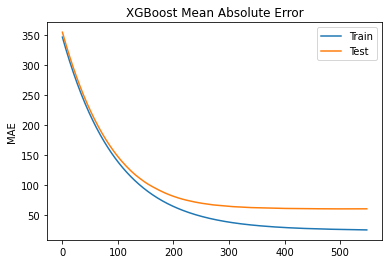

In [0]:

# retrieve performance metrics
results = full_pipeline[-1].estimator.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost Mean Absolute Error')
plt.show()

In [0]:
# print(full_pipeline[-1].estimator.feature_importances_)
# importances = full_pipeline[-1].estimator.feature_importances_
# feature_cols = X_train.columns

# importance_dict = {}
# for i in range(len(feature_cols)):
#     importance_dict[feature_cols[i]] = importances[i]

# print(importance_dict)

# import matplotlib.pyplot as plt
# indices = np.argsort(importances)
# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.barh(range(X_train.shape[1]), importances[indices],
#        color="b", align="center")
# # If you want to define your own labels,
# # change indices to a list of labels on the following line.
# plt.yticks(range(X_train.shape[1]), indices)
# plt.ylim([-1, X_train.shape[1]])
# plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error, max_error

print("MAE for correct predictions: ",mean_absolute_error(y_eval, preds))
print("Max Error for correct predictions: ", max_error(y_eval, preds))

print("MAE for incorrect predictions: ",mean_absolute_error(incorrect_fare, incorrect_preds))
print("Max Error for incorrect predictions: ", max_error(incorrect_fare, incorrect_preds))

MAE for correct predictions:  32.97452298778047
Max Error for correct predictions:  1042.311640625
MAE for incorrect predictions:  456.35974093975796
Max Error for incorrect predictions:  25175.673889160156


In [0]:
# CV = 5

# mae = cross_val_score(estimator, correct_df, fare_df.fare, scoring='neg_mean_absolute_error', cv=CV)
# print("Average MAE: {}".format(mae.mean()))

In [0]:
correct_error = abs(y_eval['fare']-preds)
correct_percentile = np.percentile(correct_error, 98)

incorrect_error = abs(incorrect_fare['fare']-incorrect_preds)
incorrect_percentile = np.percentile(incorrect_error, 40)

print("correct_percentile: ", correct_percentile)
print("incorrect_percentile: ", incorrect_percentile)

correct_percentile:  174.5950292968753
incorrect_percentile:  128.3415289306641


In [0]:
percentile = 140
true = []
predicted = []

for i in range(len(correct_error)):
    true.append(1)
    if correct_error.values[i] <= percentile:
        predicted.append(1)
    else:
        predicted.append(0)

    if i == len(correct_error) - 1:
        print("Correct accuracy: ", accuracy_score(true, predicted))

for j in range(len(incorrect_error)):
    true.append(0)
    if incorrect_error.values[j] <= percentile:
        predicted.append(1)
    else:
        predicted.append(0)

print(true)
print(predicted)

Correct accuracy:  0.9702907711757269
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [0]:
from sklearn.metrics import f1_score, accuracy_score


print(f1_score(true, predicted, average='macro'))
print(f1_score(true, predicted))
print(accuracy_score(true, predicted,))

0.8073992248062015
0.921
0.8744038155802861


# Predicting Results

In [0]:
estimator = XGBRegressor(max_depth=10, learning_rate=0.01, eval_metric='rmse', iterations=474)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [0]:
%%time 

full_pipeline.fit(correct_df, fare_df)
None

[15:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1.72 s, sys: 6.77 ms, total: 1.73 s
Wall time: 1.74 s


In [0]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

test_features_df, test_fare = test_feature_process(test_features_df)
print(test_features_df.shape)
test_features_df.head()

In [0]:
test_predictions = full_pipeline.predict(test_features_df)
test_predictions

array([ 187.03957, 1015.00714,  189.65692, ...,   76.45001,  156.11526,
        181.85426], dtype=float32)

In [0]:
error = abs(test_fare - test_predictions)
predicted = []

for i in range(len(error)):
    if error.values[i] <= percentile:
        predicted.append(1)
    else:
        predicted.append(0)

In [0]:
predicted[:10]

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1]

In [0]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = predicted

submission_df.head()

In [0]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/TaxiFare/my_submission.csv', index=True)

In [0]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/TaxiFare/my_submission.csv